# MNIST 구현

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

In [2]:
df = pd.read_csv('data/mnist/train.csv')
display(df.head(), df.shape)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(42000, 785)

## 데이터의 명세를 파악해보자.
* 픽셀값: 0~225 사이의 정수값
* 픽셀값이 클수록 어두운 색상
<br>

Reference: [Digit Recognizer](https://www.kaggle.com/c/digit-recognizer/data)

## 결측치, 이상치
이미지에서 뽑은 데이터(픽셀값)이므로 이상치와 결측치가 존재하지 않는다.

## Data Visualization

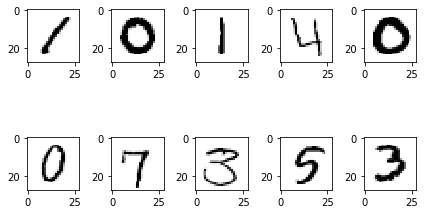

In [3]:
img_data = df.drop('label', axis=1, inplace=False).values # 픽셀 데이터 (2차원 ndarray)

fig = plt.figure() # 도화지
fig_arr = [] # 10개의 subplot을 생성해서 그 각각의 subplot을 리스트에 저장

for n in range(10):
    fig_arr.append(fig.add_subplot(2,5, n+1)) # 2행 5열, 몇번째: 1번째 부터 시작
    fig_arr[n].imshow(img_data[n].reshape(28,28), cmap='Greys', interpolation='nearest') 
plt.tight_layout()
plt.show()

## 데이터 분할

In [4]:
x_data_train, x_data_test, t_data_train, t_data_test = \
train_test_split(df.drop('label', axis=1, inplace=False), df['label'], test_size=0.3, random_state=0) # (2차원, 1차원)

## 정규화

In [5]:
scaler = MinMaxScaler()
scaler.fit(x_data_train)
x_data_train_norm = scaler.transform(x_data_train)

scaler.fit(x_data_test)
x_data_test_norm = scaler.transform(x_data_test)

## One-hot Encoding

In [6]:
sess = tf.Session()
t_data_train_onehot = sess.run(tf.one_hot(t_data_train, depth=10)) 
t_data_test_onehot = sess.run(tf.one_hot(t_data_test, depth=10))

## Tensorflow Graph

In [7]:
# placeholder
X = tf.placeholder(shape=[None, 784], dtype=tf.float32)
T = tf.placeholder(shape=[None, 10], dtype=tf.float32)

# Weight & bias
W = tf.Variable(tf.random.normal([784, 10]), name='weight') # 7840개
b = tf.Variable(tf.random.normal([10]), name='bias') # 10개
        
# Hypothesis
logit = tf.matmul(X,W) + b
H = tf.nn.softmax(logit)

# loss
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logit, labels=T))

# gradient descent algorithm
train = tf.train.GradientDescentOptimizer(learning_rate=1e-1).minimize(loss)

## Learning

In [8]:
# parameter
num_of_epoch = 1000
batch_size = 100

def run_train(sess, train_x, train_t):
    print('=====START LEARNING=====')
    
    # 초기화
    sess.run(tf.global_variables_initializer())
    
    # 반복학습
    for step in range(num_of_epoch):
        total_batch = int(train_x.shape[0] / batch_size)
        
        for i in range(total_batch):
            batch_x = train_x[i*batch_size: (i+1)*batch_size]
            batch_t = train_t[i*batch_size: (i+1)*batch_size]
            
            _, loss_val = sess.run([train, loss], feed_dict={X: batch_x, T: batch_t})
        
        if step % 100 == 0:
            print('Loss: {}'.format(loss_val))
    print('=====FINISH LEARNING=====')

## Accuracy

In [9]:
predict = tf.argmax(H, axis=1)
correct = tf.equal(predict, tf.argmax(T, axis=1))
accuracy = tf.reduce_mean(tf.cast(correct, dtype=tf.float32))

## K-fold Cross Validation

In [10]:
cv = 5
results = []

kf = KFold(n_splits=cv, shuffle=True)

for training_idx, validation_idx in kf.split(x_data_train_norm):
    # fancy indexing
    training_x = x_data_train_norm[training_idx]
    training_t = t_data_train_onehot[training_idx]
    
    validation_x = x_data_train_norm[validation_idx]
    validation_t = t_data_train_onehot[validation_idx]
    
    # learning
    run_train(sess, training_x, training_t)
    
    # validation
    results.append(sess.run(accuracy, feed_dict={X: validation_x, T: validation_t}))
    
final_acc = np.mean(results)
print('각 Fold의 Accuracy: {}'.format(results))
print('K-fold Validation을 통한 우리 모델의 Accuracy: {}'.format(final_acc))

=====START LEARNING=====
Loss: 2.6306164264678955
Loss: 0.273072749376297
Loss: 0.20051433145999908
Loss: 0.1790030598640442
Loss: 0.16765278577804565
Loss: 0.160324364900589
Loss: 0.1551019251346588
Loss: 0.15109921991825104
Loss: 0.14783591032028198
Loss: 0.14503581821918488
=====FINISH LEARNING=====
=====START LEARNING=====
Loss: 2.6717844009399414
Loss: 0.2418769896030426
Loss: 0.2040814906358719
Loss: 0.1878291666507721
Loss: 0.17785966396331787
Loss: 0.17077237367630005
Loss: 0.1652175486087799
Loss: 0.1606026291847229
Loss: 0.15665549039840698
Loss: 0.15322643518447876
=====FINISH LEARNING=====
=====START LEARNING=====
Loss: 3.164097309112549
Loss: 0.2489638477563858
Loss: 0.18074050545692444
Loss: 0.14939309656620026
Loss: 0.13214631378650665
Loss: 0.12165557593107224
Loss: 0.11470924317836761
Loss: 0.1097869798541069
Loss: 0.10611943900585175
Loss: 0.10327891260385513
=====FINISH LEARNING=====
=====START LEARNING=====
Loss: 2.8543174266815186
Loss: 0.2485610842704773
Loss: 0.1

## Testing

In [11]:
run_train(sess, x_data_train_norm, t_data_train_onehot)
final_accuracy = sess.run(accuracy, feed_dict={X: x_data_test_norm, T: t_data_test_onehot})
print('우리 모델의 최종 Accuracy: {}'.format(final_accuracy))

=====START LEARNING=====
Loss: 1.8459428548812866
Loss: 0.2462705671787262
Loss: 0.19432052969932556
Loss: 0.17188483476638794
Loss: 0.16010664403438568
Loss: 0.15301412343978882
Loss: 0.1483079344034195
Loss: 0.14495432376861572
Loss: 0.1424129456281662
Loss: 0.140374094247818
=====FINISH LEARNING=====
우리 모델의 최종 Accuracy: 0.9149206280708313


## Evaluation Matrix
* Precision
* Recall
* F1
* Accuracy

In [12]:
names = ['num 0', 'num 1', 'num 2', 'num 3', 'num 4', 'num 5', 'num 6', 'num 7', 'num 8', 'num 9']
report = classification_report(t_data_test, 
                               sess.run(predict, feed_dict={X: x_data_test_norm}),
                               target_names=names)
print(report)

              precision    recall  f1-score   support

       num 0       0.96      0.95      0.95      1242
       num 1       0.95      0.97      0.96      1429
       num 2       0.91      0.89      0.90      1276
       num 3       0.90      0.89      0.89      1298
       num 4       0.92      0.91      0.92      1236
       num 5       0.87      0.87      0.87      1119
       num 6       0.93      0.95      0.94      1243
       num 7       0.94      0.92      0.93      1334
       num 8       0.88      0.87      0.88      1204
       num 9       0.87      0.90      0.89      1219

    accuracy                           0.91     12600
   macro avg       0.91      0.91      0.91     12600
weighted avg       0.91      0.91      0.91     12600



# Confusion Matrix
## Sample Code
3개의 label(정답)이 있는 multinomial classification에 대해 예측값을 넣어서 confusion matrix를 출력

In [13]:
from sklearn.metrics import confusion_matrix
y_true = [2, 0, 2, 2, 0, 1] # 정답
y_pred = [0, 0, 2, 2, 0, 2] # 예측값
print(confusion_matrix(y_true, y_pred)) # 2차원 ndarray

[[2 0 0]
 [0 0 1]
 [1 0 2]]


## MNIST 적용

In [14]:
confusion_mtrx = confusion_matrix(t_data_test, sess.run(predict, feed_dict={X: x_data_test_norm}))
                     
print(confusion_mtrx) # 예) 49: 3을 5로 잘못 예측

[[1184    0   11    4    2   11   21    0    7    2]
 [   0 1391    8    6    1    3    5    0   12    3]
 [  10   19 1137   31   16    6   16   14   18    9]
 [   6    4   29 1159    1   49    3    9   23   15]
 [   4   14    9    2 1126    4   11    5   10   51]
 [   8    7    7   36    7  977   20    4   42   11]
 [   6    3   11    0   15   16 1186    0    6    0]
 [   2    6   19    8   18    5    0 1224    7   45]
 [   6   16   14   33    6   42   12    4 1050   21]
 [  13    3    3   13   31    9    0   41   12 1094]]


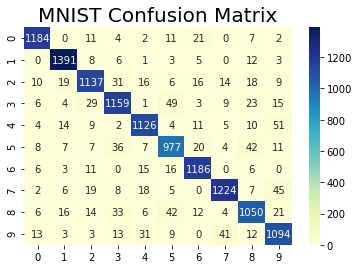

In [18]:
import seaborn as sns

sns.heatmap(confusion_mtrx, annot=True, fmt='d', cmap='YlGnBu')
plt.title('MNIST Confusion Matrix', fontsize=20)
plt.show()

## 실제 이미지를 가지고 예측
이미지 전처리 필요 (우리 모델이 예측할 수 있는 형태로 입력 데이터를 가공해주어야 함)
* 이미지 하나 구하기
* 입력 이미지 -> 예측

(572, 406, 3)
(572, 406)


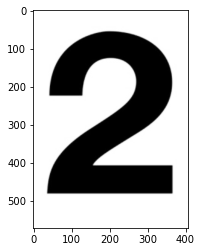

이미지의 크기: 232232
이미지의 형태: (572, 406)


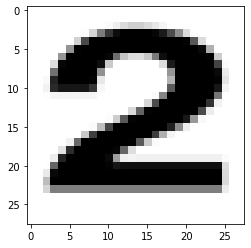

예측값: [8]


In [30]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# 이미지 파일을 컬러로 읽어오기
my_img = cv2.imread('data/mnist/number.jpg', cv2.IMREAD_COLOR) 
print(my_img.shape) # (572, 406, 3)

# 컬러 이미지를 흑백 이미지(Grayscale)로 변경
# 즉, 3차원 데이터를 2차원 형태로 변경
im_grey = cv2.cvtColor(my_img, cv2.COLOR_BGR2GRAY) 
print(im_grey.shape) # (572, 406)

# 최종 이미지 파일을 생성 (2차원 흑백 이미지)
# MNIST의 입력 데이터
cv2.imwrite('data/mnist/number_grey.jpg', im_grey)

# 흑백 이미지 파일을 Matplotlib으로 출력해보자.
img = Image.open('data/mnist/number_grey.jpg') # JPG 객체 반환
plt.imshow(img, cmap='Greys') # 2차원 데이터에 색깔 정보가 없으므로 color map을 넣어야됨
plt.show()

# 사이즈 처리 (28x28)
pixel = np.array(img) # 이미지 객체의 픽셀 정보(2차원 ndarray)
print('이미지의 크기: {}'.format(pixel.size))
print('이미지의 형태: {}'.format(pixel.shape))

resize_img = img.resize((28,28)) # resize(tuple): Pillow 기능 중 하나로 이미지 처리가 쉬워짐
plt.imshow(resize_img, cmap='Greys') # 2차원 데이터에 색깔 정보가 없으므로 color map 넣어야됨
plt.show()

# 이미지 반전 처리 (바탕색: 흰색, 숫자: 검정색)
# 흰색: (0,0,0)을 검정색: (255,255,255)로 반전하기 위해서는 255에서 현재 RGB 값을 빼면 된다.
img_grey = 255 - np.array(resize_img)

# 픽셀 정규화 처리
x_img = img_grey.reshape(-1, 784)
x_img_norm = scaler.transform(x_img)

# Prediction
result = sess.run(predict, feed_dict={X: x_img_norm})
print('예측값: {}'.format(result))